# Filter Code

This notebook holds the classes and associated methods to run noisy data through a simulated filter, analyze agreements with ground truth data, and graph the analysis. Filters are built from integrators and their parameters are optimized. 

## Modules and Libraries

Scipy has Runga-Kutta integrators which are used for timestepping (we use RK-45, but other schemes are compatible and can be used), while we use the curve_fit optimizer to optimize the filter's parameters. MatPlotLib is used for graphing, and NumPy is used for data handling. 


In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import signal
from scipy.optimize import curve_fit
import math
from typing import Optional
import os

## Filter Classes

The two classes of filters used are the timestepped filters (directly derived from circuit lowpass and highpass filters) and Butterworth filters (obtained from the scipy library). The timestepped filters are integrated using a Runga-Kutta 45 scheme, but can suffer from phase shift at the cost of high resolution. Butterworth filters feature a steeper cutoff at critical frequncies but can be susceptible to reverberation. scipy.optimize.curve_fit tends to find local minima, so sampling over a acceptably large domain is manually implemented. Error is quantified using Mean Squared Error. 

In [72]:
#root class for all filters
class Filters:
    def __init__(self, tspan, signal):
        self.tspan = tspan
        self.signal = signal
        self.temp = None
    
    # Used to find nearest time index for RK45 integrator
    def find_nearest(self, array, value):
        idx = np.searchsorted(array, value, side='left')
        if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
            return idx-1
        else:
            return idx
    
    # Scale and vertical shift optimized after filtration
    def transform(self, t, scale, shift):
        return scale*self.temp[np.where(self.tspan==t)]+shift
    
    # Graphing frequency domain plot of signal
    def graphFFT(self, freq, PSD, L):
        plt.plot(freq[L], PSD[L], label='Frequency Domain Representation of Signal')
        plt.yscale('log')
        plt.xlabel('Frequencies')
        plt.ylabel('Frequency Strength')
        plt.title('Frequency Spectrum Representation of Signal')
        plt.show()
    
    # Generates frequency domain data as well as returning the "strongest" signal
    def maxFreq(self, interval):
        n = len(self.signal)
        fhat = np.fft.fft(self.signal, n)
        powerspectrum = fhat * np.conj(fhat) / n
        freq = 1/interval*np.arange(n)#*2*np.pi
        L = np.arange(1, np.floor(n/2), dtype='int')
        maxfreqidx = np.where(powerspectrum[L]==np.max(powerspectrum[L]))
        maxFreq = freq[L][maxfreqidx]
        return freq, powerspectrum, L, maxFreq
    
    # Takes strongest signal and superpositions it with 100 odd harmonics of that frequency 
    def superPosition(self, maxFreq):
        sin = lambda t, omega: np.sin(omega*t)
        superWave = 0
        for wave in range(1, 100):
            omega = (2*wave+1)*maxFreq*2*np.pi
            superWave += (1/(2*wave+1))*sin(self.tspan, omega)
        return self.signal + superWave * 4/np.pi
    
    def signaltonoise(self, filtered, truth): #a, axis=0, ddof=0
        #a = np.asanyarray(a)
        #m = a.mean(axis)
        #sd = a.std(axis=axis, ddof=ddof)
        #return np.abs(np.where(sd == 0, 0, m/sd))
        n = len(truth)
        fhat = np.fft.fft(truth, n)
        truth_powspec = fhat * np.conj(fhat) / n
        
        fhat = np.fft.fft(filtered, n)
        filt_powspec = fhat * np.conj(fhat) / n
        
        noise = np.linalg.norm(np.abs(truth_powspec - filt_powspec))
        signal = np.linalg.norm(truth)
        
        SNR = 10*np.log10(signal/noise)
        return SNR
        
        
    
    
    # Loss function of filtered against ground truth
    def relErr(self, filtered, truth):
        diff = np.empty_like(filtered)
        diff = truth-filtered
        diffmag = np.linalg.norm(diff)
        mse = diffmag**2/diff.size
        
        SNR = self.signaltonoise(filtered, truth) #, axis = 0, ddof = 0
        steepness = 100
        cutoffSNR = -2
        grow = np.exp(-1*steepness*(cutoffSNR-SNR))
        logitterm = 1+1/(1+grow)
            
        return logitterm*mse

## Time Stepped Filters

These are directly implemented by solving the differential equations governming circuit lowpass and highpass filters. Bandpass is a lowpass chained together with a highpass filter. These equations are derived from the following:
- The sum of potential differences around a loop in a circuit must be zero (Kirchoff's Loop Rule)
- The sum of currents entering a junction is equal to the sum of currents leaving the junction (Kirchoff's Junction Rule) 
- Capacitor Voltage: $\frac{dV}{dt} = \frac{1}{C}I$
- Inductor Voltage: $V = L\frac{dI}{dt}$
- Resistor Voltage: $V = IR$

In [73]:
# Directly transferred from circuits        
class TimesteppedFilters(Filters):
    
    # Returns function derivative at discrete points for timestepping(tspan)
    def __init__(self, tspan, signal):
        super().__init__(tspan, signal)
        
    def lowpassdisc(self, t, y, signal, tau):
        dydt = (1/tau)*(signal[self.find_nearest(self.tspan, t)]-y)
        return dydt
    
    def highpassdisc(self, t, y, signal, tau):
        idx = self.find_nearest(self.tspan, t) #np.where(self.tspan==t)[0]
        dydt = (signal[idx]-signal[idx-1])/(self.tspan[idx]-self.tspan[idx-1])-y/tau
        return dydt       

    # Integrators for filter equations; what NN will pass predicted parameters to
    def solvelow(self, tau, scale, shift):
        sol_low = solve_ivp(lambda t, y, *args: self.lowpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],
                            y0=[self.signal[0]], t_eval=self.tspan, args=[self.signal, tau])
        return sol_low.y[0, :]*scale+shift
    
    def solvehigh(self, tau, scale, shift):
        sol_high = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],
                             y0=[self.signal[0]], t_eval=self.tspan, args=[self.signal, tau])
        return sol_high.y[0]*scale+shift
    
    def solvebandpass(self, tau1, tau2, scale1, scale2, shift1, shift2):
        lowpass = self.solvelow(tau1, scale1, shift1)
        bandpass = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],
                             y0=[self.signal[0]], t_eval=self.tspan, args=[lowpass, tau2])
        return bandpass.y[0]*scale2+shift2
    
    # Crude minimal global error
    def optSolve(self, truth, ftype):
        if ftype=='lowpass':
            params = np.empty(3)
            tau = 0.01
            sol = solve_ivp(lambda t, y, *args: self.lowpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],
                            y0=[self.signal[0]], t_eval=self.tspan, args=[self.signal, tau])  
            mintau = 0.01
            self.temp = sol.y[0]
            popt, pcov = curve_fit(f=self.transform, xdata=self.tspan, ydata=truth)
            minscale, minshift = popt
            minerr = self.relErr(sol.y[0]*minscale + minshift, truth)
            #print(minerr)
            #sample range of taus and find most effective one
            for n in range(1, 50):
                tau = n*0.075
                sol = solve_ivp(lambda t, y, *args: self.lowpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],
                                y0=[self.signal[0]], t_eval=self.tspan, args=[self.signal, tau])  
                self.temp = sol.y[0]#*minscale
                
                #integrate 50 times, but optimize scale/shift 250 times
                for scale in range (5):
                    popt, pcov = curve_fit(f=self.transform, xdata=self.tspan, ydata=truth, p0=[scale*0.19, 0])
                    scale, shift = popt
                    soln = scale*sol.y[0]+shift
                    err = self.relErr(soln, truth) 
                    #print(err)
                    if err < minerr:  #np.linalg.norm(err)**2/err.size
                        minerr, mintau, minscale, minshift = err, tau, scale, shift
            
            params[0] = minscale
            params[1] = mintau
            params[2] = minshift
            bestsolve = solve_ivp(lambda t, y, *args: self.lowpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],
                                  y0=[self.signal[0]], t_eval=self.tspan, args=[self.signal, mintau])  
            bestsolve.y[0] = minscale*bestsolve.y[0]+minshift
            #print(minerr)
            return bestsolve, params
        
        elif ftype=='highpass':
            params = np.empty(3)
            tau = 0.01
            sol = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],
                            y0=[self.signal[0]], t_eval=self.tspan, args=[self.signal, tau])  
            mintau = 0.01
            self.temp = sol.y[0]
            popt, pcov = curve_fit(f=self.transform, xdata=self.tspan, ydata=truth)
            minscale, minshift = popt
            minerr = self.relErr((sol.y[0]*minscale+minshift), truth)
            #print(minerr)
            for n in range(1, 50):
                tau = n*0.075
                sol = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],
                                y0=[self.signal[0]], t_eval=self.tspan, args=[self.signal, tau])  
                
                self.temp = sol.y[0]
                
                for scale in range (5):
                    popt, pcov = curve_fit(f=self.transform, xdata=self.tspan, ydata=truth, p0=[scale*0.19, 0])
                    scale, shift = popt
                    soln = scale*sol.y[0]+shift
                    err = self.relErr(soln, truth) 
                    
                    if err < minerr:  #np.linalg.norm(err)**2/err.size
                        minerr, mintau, minscale, minshift = err, tau, scale, shift
            
            params[0] = minscale
            params[1] = mintau
            params[2] = minshift
            bestsolve = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],
                                  y0=[self.signal[0]], t_eval=self.tspan, args=[self.signal, mintau])  
            bestsolve.y[0] = bestsolve.y[0]*minscale+minshift
            #print(minerr)
            return bestsolve, params            
        
        elif ftype=='bandpass':
            low, lowparam = self.optSolve(truth, ftype='lowpass') #recursive use of function to solve low pass first 
            params = np.empty(6)
            tau = 0.01
            sol = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],
                            y0=[self.signal[0]], t_eval=self.tspan, args=[low.y[0], tau])  
            mintau = 0.01
            self.temp = sol.y[0]
            popt, pcov = curve_fit(f=self.transform, xdata=self.tspan, ydata=truth)
            minscale, minshift = popt
            minerr = self.relErr((sol.y[0]*minscale+minshift), truth)
            #print(minerr)
            for n in range(1, 50):
                tau = n*0.075
                sol = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],
                                y0=[self.signal[0]], t_eval=self.tspan, args=[low.y[0], tau])  
                
                self.temp = sol.y[0]
                for scale in range (5):
                    popt, pcov = curve_fit(f=self.transform, xdata=self.tspan, ydata=truth, p0=[scale*0.19, 0])
                    scale, shift = popt
                    soln = scale*sol.y[0]+shift
                    err = 0# np.empty_like(truth)
                    err = self.relErr(soln, truth) 
                    
                    if err < minerr:  #np.linalg.norm(err)**2/err.size
                        minerr, mintau, minscale, minshift = err, tau, scale, shift
            
            params[0] = lowparam[0]
            params[1] = lowparam[1]
            params[2] = lowparam[2]
            params[3] = minscale
            params[4] = mintau
            params[5] = minshift
            bestsolve = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],
                                  y0=[self.signal[0]], t_eval=self.tspan, args=[low.y[0], mintau]) 
            bestsolve.y[0] = minscale*bestsolve.y[0]+minshift
            #print(minerr)
            return bestsolve, params

    # Graphing filtration, option to graph alongside truth signal
    def graph(self, opt, ftype, truth=None):
        sol = opt[0]
        params = opt[1]
        plt.plot(sol.t, sol.y[0,:], label='Filtered', color='red')
        if truth is not None:
            plt.plot(self.tspan, truth,'--', label='Ground truth', color='black')
            print('Loss Value: ', self.relErr(sol.y[0,:], truth))
        if ftype=='Low Pass':
            plt.title('%s, RK45 Integrator, Params [Scale: %f, Tau: %f, V-Shift: %f]' % (ftype, params[0], 
                                                                                                params[1], 
                                                                                                params[2]))
        elif ftype=='High Pass':
            plt.title('%s, RK45 Integrator, Params [Scale: %f, Tau: %f, V-Shift: %f]' % (ftype, params[0], 
                                                                                                params[1], 
                                                                                                params[2]))
        elif ftype=='Band Pass':
            plt.title('%s, RK45 Integrator, Params [Scales: %f, %f, Taus: %f, %f, V-Shifts: %f, %f]' % (ftype, 
                                                                                     params[0], 
                                                                                     params[3], 
                                                                                     params[1],
                                                                                     params[4],
                                                                                     params[2],
                                                                                     params[5]))
        plt.xlabel('Nanopore Measurements')
        plt.ylabel('Ionic Current (pA)')                                                                                 
        plt.legend(loc='upper right')
        plt.margins(0.05, 0.4)
        plt.show()

## Butterworth Filters

These filters are not directly derived to integrate, but rather are from scipy's signal library. Butterworth filters differ from time-stepped filters due to their sharper frequency cutoff. The steepness of the Butterworth cutoff allows less noise, but makes them susceptible to increased reverberative effects. Similar to the timestepped filters, sampling is manually instituted over an acceptably large domain. 

Another filter type we are considering are the Chebyshev class of filters. We may institute these later if these filters do not prove effective at increasing basecalling single-read accuracy. 

In [74]:
# Digital Butterworth Filters        
class ButterworthFilters(Filters):

    def __init__(self, tspan, signal):
        super().__init__(tspan, signal)  
    
    #Butterworth filter solvers for input parameters
    def lbutt(self, t, order, freq0):
        order = int(order)
        freqarray = np.empty(1)
        freqarray[0] = freq0
        b, a = signal.butter(order, freqarray, btype='lowpass')
        y = signal.filtfilt(b, a, self.signal)
        return y[np.where(self.tspan==t)]
    
    def hbutt(self, t, order, freq0):
        order = int(order)
        freqarray = np.empty(1)
        freqarray[0] = freq0
        b, a = signal.butter(order, freqarray, btype='highpass')
        y = signal.filtfilt(b, a, self.signal)
        return y[np.where(self.tspan==t)]
    
    def bpassbutt(self, t, order, freq0, freq1):
        order = int(order)
        freqarray = np.empty(2)
        freqarray[0] = freq0
        freqarray[1] = freq1
        b, a = signal.butter(order, freqarray, btype='bandpass')
        y = signal.filtfilt(b, a, self.signal)
        return y[np.where(self.tspan==t)]
    
    def bstopbutt(self, t, order, freq0, freq1):
        order = int(order)
        freqarray = np.empty(2)
        freqarray[0] = freq0
        freqarray[1] = freq1
        b, a = signal.butter(order, freqarray, btype='bandstop')
        y = signal.filtfilt(b, a, self.signal)
        return y[np.where(self.tspan==t)] 
   
    # Optimizes Butterworth filter parameters, sampling over whole domain for global minima
    def optSolve(self, orders, truth, ftype):
        if ftype=='lowpass':             
            popt, pcov = curve_fit(self.lbutt, self.tspan, truth, p0=[1, 0.5], 
                                   bounds=(0, [np.inf, 0.99]))
            minerr = self.relErr(self.lbutt(self.tspan, *popt), truth)
            minorder = 1
            for order in range (2, orders):
                popt, pcov = curve_fit(self.lbutt, self.tspan, truth, p0=[order, 0.5], 
                                       bounds=(0, [np.inf, 0.99]))
                err = self.relErr(self.lbutt(self.tspan, *popt), truth)
                if (err < minerr):
                    minorder = order
                    minerr = err
            minpopt, minpcov = curve_fit(self.lbutt, self.tspan, truth, p0=[minorder, 0.5], 
                                         bounds=(0, [np.inf, 0.99]))
            y = self.lbutt(self.tspan, *minpopt)
            return y, minpopt
            
        elif ftype=='highpass':  
            popt, pcov = curve_fit(self.hbutt, self.tspan, truth, p0=[1, 0.01], 
                                   bounds=(0, [np.inf, 0.99]))
            minerr = self.relErr(self.hbutt(self.tspan, *popt), truth)
            minorder = 1
            for order in range (2, orders):
                popt, pcov = curve_fit(self.hbutt, self.tspan, truth, p0=[order, 0.01], 
                                       bounds=(0, [np.inf, 0.99]))
                err = self.relErr(self.hbutt(self.tspan, *popt), truth)
                if (err < minerr):
                    minorder = order
                    minerr = err
            minpopt, minpcov = curve_fit(self.hbutt, self.tspan, truth, p0=[minorder, 0.01], 
                                         bounds=(0, [np.inf, 0.99]))
            y = self.hbutt(self.tspan, *minpopt)
            return y, minpopt                
           
        elif ftype=='bandpass':  
            popt, pcov = curve_fit(self.bpassbutt, self.tspan, truth, p0=[1, 0.01, 0.99], 
                                   bounds=(0, [np.inf, 0.99, 0.99]))
            minerr = self.relErr(self.bpassbutt(self.tspan, *popt), truth)
            minorder = 1
            for order in range (2, orders):
                popt, pcov = curve_fit(self.bpassbutt, self.tspan, truth, p0=[order, 0.01, 0.99], 
                                       bounds=(0, [np.inf, 0.99, 0.99]))
                err = self.relErr(self.bpassbutt(self.tspan, *popt), truth)
                if (err < minerr):
                    minorder = order
                    minerr = err
            minpopt, minpcov = curve_fit(self.bpassbutt, self.tspan, truth, p0=[minorder, 0.01, 0.99], 
                                         bounds=(0, [np.inf, 0.99, 0.99]))
            y = self.bpassbutt(self.tspan, *minpopt)
            return y, minpopt 
        
        elif ftype=='bandstop':  
            popt, pcov = curve_fit(self.bstopbutt, self.tspan, truth, p0=[1, 0.01, 0.99], 
                                   bounds=(0, [np.inf, 0.99, 0.99]))
            minerr = self.relErr(self.bstopbutt(self.tspan, *popt), truth)
            minorder = 1
            for order in range (2, orders):
                popt, pcov = curve_fit(self.bstopbutt, self.tspan, truth, p0=[order, 0.01, 0.99], 
                                       bounds=(0, [np.inf, 0.99, 0.99]))
                err = self.relErr(self.bstopbutt(self.tspan, *popt), truth)
                if (err < minerr):
                    minorder = order
                    minerr = err
            minpopt, minpcov = curve_fit(self.bstopbutt, self.tspan, truth, p0=[minorder, 0.01, 0.99], 
                                         bounds=(0, [np.inf, 0.99, 0.99]))
            y = self.bstopbutt(self.tspan, *minpopt)
            return y, minpopt 
    
    # Graphing filtration, option to graph alongside truth signal
    def graph(self, y, popt, ftype, truth=None):
        plt.plot(self.tspan, y, label='Filtered', color='red')
        if truth is not None:
            plt.plot(self.tspan, truth,'--', label='Ground truth', color='black')
            print('Loss Value: ', self.relErr(y, truth))
        if ftype=='Low Pass' or ftype=='High Pass':
            plt.title('Butterworth type: %s, Params [Ord: %d, Freq: %f]' % (ftype, int(popt[0]), popt[1]))
        elif ftype=='Band Pass' or ftype=='Band Stop':
            plt.title('Butterworth type: %s, Params [Ord: %d, Freqs: %f, %f]' % (ftype, int(popt[0]), 
                                                                              popt[1], popt[2]))
        plt.legend(loc='upper right')
        plt.margins(0.05, 0.4)
        plt.xlabel('Nanopore Measurements')
        plt.ylabel('Ionic Current (pA)')  
        plt.show()

# Potential Chebyshev filters to add in the future:

#b, a = scipy.signal.cheby1(1, 20, 0.2)
#y = scipy.signal.filtfilt(b, a, Vinarray)
#plt.plot(tspan,  y)

#b, a = scipy.signal.cheby2(1, 20, 0.2)
#y = scipy.signal.filtfilt(b, a, Vinarray)
#plt.plot(tspan, y)

## Demonstrated Examples

The 1st signal to extract is a simple, continuous sine wave, but we add copious noise to the waveform at a variety of frequencies.

The 2nd signal is a periodic square wave with noise. This resembles the type of data we would be working with a bit better.

We run the signals through the filters, optimize their parameters to fit against the ground truth, and graph the results with parameter labels in order to analyze which filters appear most effective.

Example 1: Sine Wave


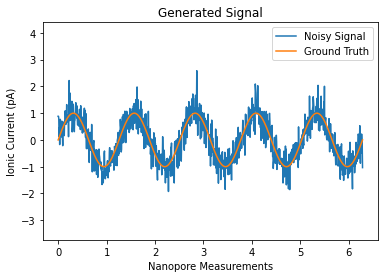

Strongest frequency at: 0.7957747154594768


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


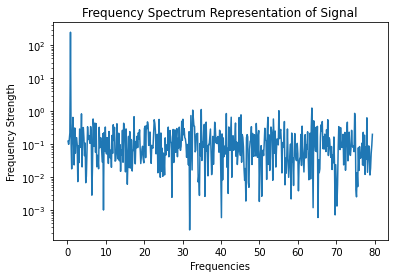

Loss Value:  0.07493958340151526


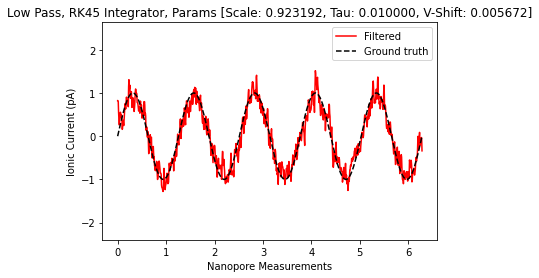

Loss Value:  0.2836414371059875


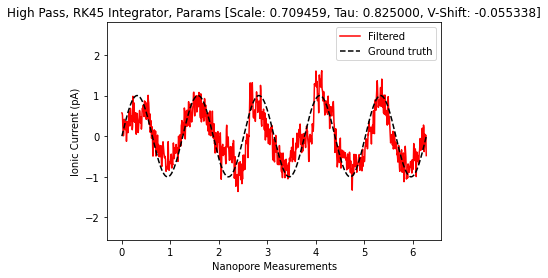

Loss Value:  0.08885630663438883


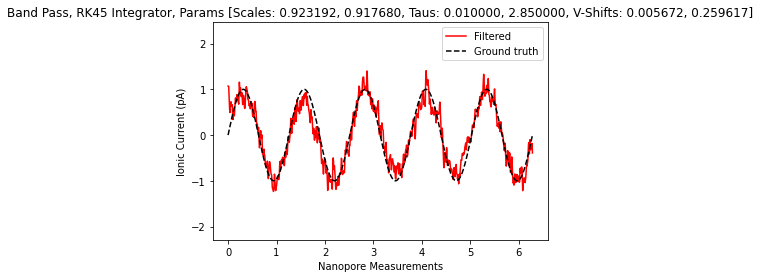

<ipython-input-72-18c1f33646ed>:80: RuntimeWarning: overflow encountered in exp
  grow = np.exp(-1*steepness*(cutoffSNR-SNR))


Loss Value:  0.009106475013354294


<ipython-input-72-18c1f33646ed>:80: RuntimeWarning: overflow encountered in exp
  grow = np.exp(-1*steepness*(cutoffSNR-SNR))


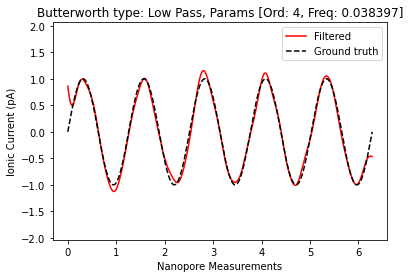

Loss Value:  0.4246433010564549


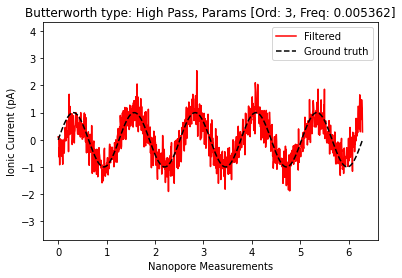

Loss Value:  0.08067496510678669


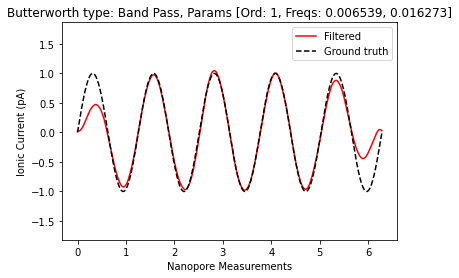

<ipython-input-72-18c1f33646ed>:80: RuntimeWarning: overflow encountered in exp
  grow = np.exp(-1*steepness*(cutoffSNR-SNR))


Loss Value:  0.012842022435457444


<ipython-input-72-18c1f33646ed>:80: RuntimeWarning: overflow encountered in exp
  grow = np.exp(-1*steepness*(cutoffSNR-SNR))


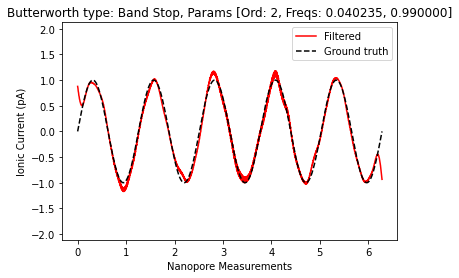

Example 2: Square Wave


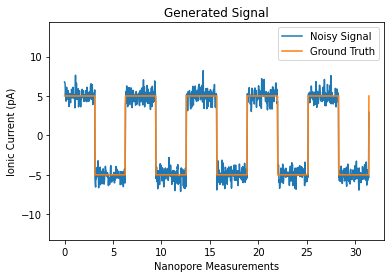

Loss Value:  0.9051683855181939


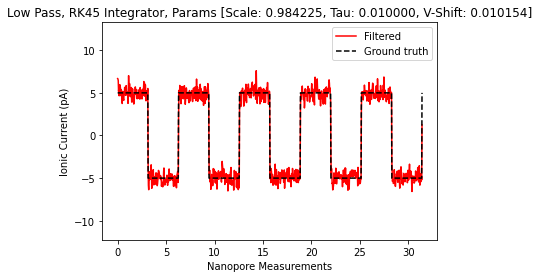

KeyboardInterrupt: 

In [75]:
# Filter simulations and graphing
# Demonstrates how to use all filters
PATH_TO_FIGURES = '/Users/aaronphilip/ScienceFair/projects/NanoporeSequencingFiltering/figures'
if __name__ == '__main__':
    
    # Example 1: Sine Wave
    print('Example 1: Sine Wave')
    np.random.seed(123456789)
    interval = 2*np.pi
    tspan =  np.linspace(0, interval, 1000)
    teval = 0
    Vin = lambda t: np.sin(5*t)
    mynoise = 0.4*np.random.randn(*Vin(tspan).shape)
    Vinarray = Vin(tspan) + mynoise
    
    plt.plot(tspan, Vinarray, label='Noisy Signal')
    plt.plot(tspan, Vin(tspan), label='Ground Truth')
    plt.legend(loc='upper right')
    plt.margins(0.05, 0.4)
    plt.title('Generated Signal')
    plt.xlabel('Nanopore Measurements')
    plt.ylabel('Ionic Current (pA)')  
    plt.show()
    #path = os.path.join(PATH_TO_FIGURES, 'noisysine.png')
    #plt.savefig(path)
    
    # Frequency Domain Representation
    filterobj = Filters(tspan, Vinarray)
    params = np.empty(3)
    params = filterobj.maxFreq(interval)
    print('Strongest frequency at:', params[3][0])
    #path = os.path.join(PATH_TO_FIGURES, 'noisysinefreq.png')
    filterobj.graphFFT(params[0], params[1], params[2])
    #plt.savefig(path)
   
    #filtering
    filtered = TimesteppedFilters(tspan, Vinarray)
    lowfilter = filtered.optSolve(Vin(tspan), ftype='lowpass')
    #path = os.path.join(PATH_TO_FIGURES, 'sinelowpass.png')
    filtered.graph(lowfilter, 'Low Pass', Vin(tspan))
    #plt.savefig(path)

    highfilter = filtered.optSolve(Vin(tspan), ftype='highpass')
    #path = os.path.join(PATH_TO_FIGURES, 'sinehighpass.png')
    filtered.graph(highfilter, 'High Pass', Vin(tspan))
    #plt.savefig(path)

    bandpassfilter = filtered.optSolve(Vin(tspan), ftype='bandpass')
    #path = os.path.join(PATH_TO_FIGURES, 'sinebandpass.png')
    filtered.graph(bandpassfilter, 'Band Pass', Vin(tspan))
    #plt.savefig(path)
    
    butterworth = ButterworthFilters(tspan, Vinarray)
    butterlow = butterworth.optSolve(10, Vin(tspan), ftype='lowpass')
    #path = os.path.join(PATH_TO_FIGURES, 'sinebutterlowpass.png')
    butterworth.graph(butterlow[0], butterlow[1], 'Low Pass', truth=Vin(tspan))
    #plt.savefig(path)
    
    butterhigh = butterworth.optSolve(10, Vin(tspan), ftype='highpass')
    butterworth.graph(butterhigh[0], butterhigh[1], 'High Pass', truth=Vin(tspan))
    
    butterbpass = butterworth.optSolve(10, Vin(tspan), ftype='bandpass')
    butterworth.graph(butterbpass[0], butterbpass[1], 'Band Pass', truth=Vin(tspan))

    butterbstop = butterworth.optSolve(10, Vin(tspan), ftype='bandstop')
    butterworth.graph(butterbstop[0], butterbstop[1],'Band Stop', truth=Vin(tspan))
    
    # Example 2: Square Wave
    print('Example 2: Square Wave')
    interval = 5*2*np.pi
    tspan = np.linspace(0, interval, 1000)
    sqwave = signal.square(tspan)*5 
    np.random.seed(123456789)
    mynoise = 0.8*np.random.randn(*sqwave.shape)
    sqnoisywave = mynoise+sqwave
    plt.plot(tspan, sqnoisywave, label='Noisy Signal')
    plt.plot(tspan, sqwave, label='Ground Truth')
    plt.legend(loc='upper right')
    plt.margins(0.05, 0.4)
    plt.title('Generated Signal')
    plt.xlabel('Nanopore Measurements')
    plt.ylabel('Ionic Current (pA)')  
    plt.show()
        
    
    sqfiltered = TimesteppedFilters(tspan, sqnoisywave)
    sqlowfilter = sqfiltered.optSolve(sqwave, ftype='lowpass')
    sqfiltered.graph(sqlowfilter, 'Low Pass', truth=sqwave)
    
    sqhighfilter = sqfiltered.optSolve(sqwave, ftype='highpass')
    sqfiltered.graph(sqhighfilter, 'High Pass', truth=sqwave)
    
    sqbandpassfilter = sqfiltered.optSolve(sqwave, ftype='bandpass')
    sqfiltered.graph(sqbandpassfilter, 'Band Pass', truth=sqwave)
    
    sqbutter = ButterworthFilters(tspan, sqnoisywave)
    sqbutterlow = sqbutter.optSolve(10, sqwave, ftype='lowpass')
    sqbutter.graph(sqbutterlow[0], sqbutterlow[1], 'Low Pass', truth=sqwave)
    
    sqbutterhigh = sqbutter.optSolve(10, sqwave, ftype='highpass')
    sqbutter.graph(sqbutterhigh[0], sqbutterhigh[1], 'High Pass', truth=sqwave)
    
     # Frequency Domain Representation of Low Pass Filtered Data
    filterobj = Filters(tspan, sqlowfilter[0].y[0,:])
    params = np.empty(3)
    params = filterobj.maxFreq(interval)
    print('Strongest frequency at:', params[3][0])
    #path = os.path.join(PATH_TO_FIGURES, 'squarefreq.png')
    filterobj.graphFFT(params[0], params[1], params[2])
    #plt.savefig(path)
    
    # Attempt to use superpositioning to reconstruct square wave 
    plt.plot(tspan, filterobj.superPosition(params[3][0]), label='Filtered') #sqlowfilter[0].y[0,:]+
    plt.plot(tspan, sqwave, '--', label='Truth')
    plt.legend(loc='upper right')
    plt.margins(0.05, 0.4)
    plt.title('Odd Harmonics Superimposed on (Low Pass) Filtered Signal')
    plt.xlabel('Nanopore Measurements')
    plt.ylabel('Ionic Current (pA)')  
    plt.show()
    
    """
    sqbutterbpass = sqbutter.optSolve(10, sqwave, ftype='bandpass')
    print('Error Magnitude: ', sqbutter.relErr(sqbutterbpass[0], sqwave))
    sqbutter.graph(sqbutterbpass[0], sqbutterbpass[1], 'Band Pass', truth=sqwave)
    
    sqbutterbstop = sqbutter.optSolve(10, sqwave, ftype='bandstop')
    print('Error Magnitude: ', sqbutter.relErr(sqbutterbstop[0], sqwave))
    butterworth.graph(sqbutterbstop[0], sqbutterbstop[1],'Band Stop', truth=sqwave)
    """

## Example Analysis

In this example, highpass is not an effective filter, as we would expect. This makes sense because we are trying to extract a low frequency signal. With the nanopore DNA sequencing data however, we are generally going to be reconstructing square waves from soft, gradual curves, so the high pass should prove more effective there (square waves are the infinite sum of odd harmonics of sin waves).